# Sensitivity analysis of benchmark results

* input data ($P_{load}$ and $P_{sun}$): variability, length
* P_pv rated
* E_rated

Pierre Haessig, April 2018

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Load testcase data

In [2]:
E_rated = 10 # kWh
P_pvp = 3 # kW
P_grid_max = 3 # kW

In [199]:
df = pd.read_csv('../data/data_2011-2012.csv', index_col=0, parse_dates=True)

# slice test weeks
df = df['2011-11-29':'2011-12-28'] # 30 test days

n = len(df)
n//48

30

In [200]:
P_load = df.GC
P_sun = df.GG/1.04*P_pvp;

dt = 0.5 # hours
t = np.arange(n)*dt # hours
td = t/24 #days

In [201]:
print('Data from {} to {} ({:.0f} days)'. format(df.index.date[0], df.index.date[-1], td[-1]))
print('* average sun energy: {:.2f} kWh/d'.format(P_sun.mean()*24))
print('* average load      : {:.2f} kWh/d'.format(P_load.mean()*24))
print('* ratio sun/load: {:.2%}'.format(P_sun.mean()/P_load.mean()))

Data from 2011-11-29 to 2011-12-28 (30 days)
* average sun energy: 11.70 kWh/d
* average load      : 17.02 kWh/d
* ratio sun/load: 68.77%


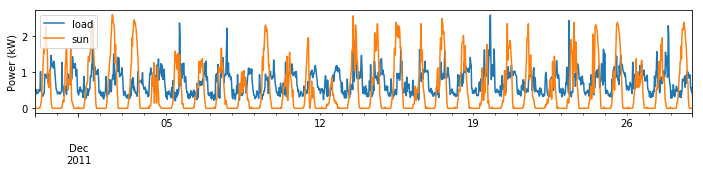

In [202]:
fig = plt.figure(figsize=(10,2.5))
P_load.plot(label='load')
P_sun.plot(label='sun')
plt.legend()
plt.ylabel('Power (kW)')
fig.tight_layout()

## Solar home simulation

using rule-based control, taken from [solar_home_rule-based-control.ipynb](../methods/python_rule-based/solar_home_rule-based-control.ipynb))

control strategy: battery should absorb absorb net production, as long as feasible:

$$P_{sto} = -P_{nl} = P_{sun} - P_{load}$$

In [11]:
def control(E_rated, P_load, P_sun, E_sto):
    P_nl = P_load - P_sun
    # outputs:
    P_sto = 0
    P_grid = 0
    P_curt = 0
    
    E_next = E_sto - P_nl*dt
    
    if P_nl>0: # (load > sun)
        E_next = E_next if E_next>0. else 0.
        P_sto = (E_next - E_sto)/dt # <0
        P_grid = P_nl + P_sto
    else:
        E_next = E_next if E_next<E_rated else E_rated
        P_sto = (E_next - E_sto)/dt # >0
        P_curt = -P_nl - P_sto
    return P_sto, P_grid, P_curt

In [12]:
def home_sim(E_rated, P_pvp, P_load, P_sun_1kW):
    '''simulate solar home with parameters `E_rated` and `P_pvp`
    and data `P_load`, `P_sun_1kW`
    '''
    n = len(P_load)
    P_sun = P_sun_1kW*P_pvp
    P_sto = np.zeros(n)
    E_sto = np.zeros(n+1)
    P_grid = np.zeros(n)
    P_curt = np.zeros(n)

    E_sto[0]= E_rated/2

    for k in range(n):
        P_sto[k], P_grid[k], P_curt[k] = control(E_rated, P_load[k], P_sun[k], E_sto[k])
        E_sto[k+1] = E_sto[k] + P_sto[k]*dt
        assert 0 <= E_sto[k+1] <= E_rated

    # extra outputs
    E_sto = E_sto[:-1]
    P_pv = P_sun - P_curt
    P_nl = P_load - P_sun
    
    # stats: cumulated energy in kWh/day
    stats = dict(
        E_load = P_load.mean()*24,
        E_sun  = P_sun.mean()*24,
        E_pv   = P_pv.mean()*24,
        E_curt = P_curt.mean()*24,
        E_grid = P_grid.mean()*24
    )
    # full output: out = pd.DataFrame()
    return stats

In [13]:
%time home_sim(E_rated, 3, P_load, P_sun/3)

CPU times: user 56 ms, sys: 0 ns, total: 56 ms
Wall time: 56.2 ms


{'E_curt': 0.0766615384615383,
 'E_grid': 5.438667948717948,
 'E_load': 17.01703333333333,
 'E_pv': 11.62641538461537,
 'E_sun': 11.70307692307691}

In [14]:
def pprint_stats(stats):
    'pretty print energy stats'
    s = '''E_load: {E_load:6.2f} kWh/d (data)
E_sun:  {E_sun:6.2f} kWh/d (data)
E_pv:   {E_pv:6.2f} kWh/d
E_curt: {E_curt:6.2f} kWh/d
E_grid: {E_grid:6.2f} kWh/d'''.format(**stats)
    print(s)

In [15]:
pprint_stats(home_sim(E_rated, 3, P_load, P_sun/3))

E_load:  17.02 kWh/d (data)
E_sun:   11.70 kWh/d (data)
E_pv:    11.63 kWh/d
E_curt:   0.08 kWh/d
E_grid:   5.44 kWh/d


## Parametric study

effect of storage size and PV size

In [66]:
nE = 41
E_rated_max = 20 # kWh
E_rated_list = np.linspace(0, E_rated_max, nE) 
dE = E_rated_list[1] - E_rated_list[0]
dE # step, kWh

0.5

In [68]:
nPV = 37
P_pv_max = 6 # kW_peak
P_pvp_list = np.linspace(0, P_pv_max, nPV) 
dP = P_pvp_list[1] - P_pvp_list[0]
dP # step, kW_peak

0.16666666666666666

In [69]:
print('nb of param values: {}. Simulation time: ~{:.1f} s'.format(nE*nPV, 40e-3*nE*nPV))

nb of param values: 1517. Simulation time: ~60.7 s


batch simulation... (40 ms/pt)

In [70]:
stats_list = []
for E_rated in E_rated_list:
    for P_pvp in P_pvp_list:
        stats = home_sim(E_rated, P_pvp, P_load, P_sun/3)
        stats['E_rated'] = E_rated
        stats['P_pvp'] = P_pvp
        stats_list.append(stats)

In [71]:
stats = pd.DataFrame(stats_list)
stats.head()

,E_curt,E_grid,E_load,E_pv,E_rated,E_sun,P_pvp
0,0.000000,17.017033,17.017033,0.000000,0.0,0.000000,0.000000
1,0.000000,16.366862,17.017033,0.650171,0.0,0.650171,0.166667
2,0.000000,15.716691,17.017033,1.300342,0.0,1.300342,0.333333
3,0.001363,15.067884,17.017033,1.949149,0.0,1.950513,0.500000
4,0.016341,14.432691,17.017033,2.584343,0.0,2.600684,0.666667


Folded output stats:

In [95]:
E_grid_rs = stats.E_grid.values.reshape((nE, nPV))
E_curt_rs = stats.E_curt.values.reshape((nE, nPV))
XP, YE = np.meshgrid(P_pvp_list, E_rated_list)

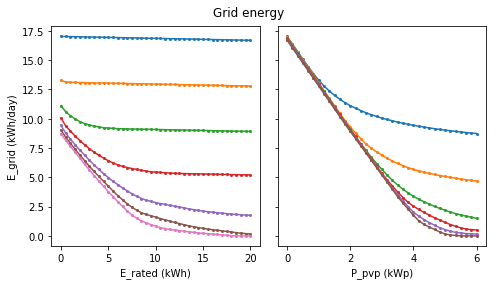

In [90]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(7,4))
ax[0].plot(E_rated_list, E_grid_rs[:,::6], 'o-', ms=2)
ax[1].plot(P_pvp_list, E_grid_rs[::8,:].T, 'o-', ms=2)

ax[0].set(xlabel='E_rated (kWh)', ylabel='E_grid (kWh/day)')
ax[1].set(xlabel='P_pvp (kWp)')
fig.suptitle('Grid energy')
fig.tight_layout(rect=(0, 0, 1, 0.96))

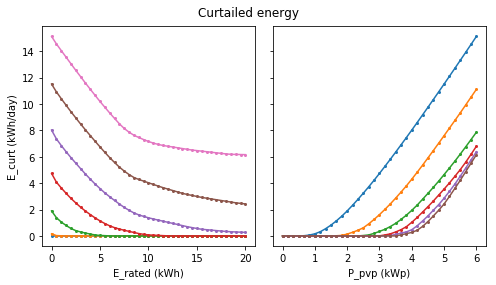

In [89]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(7,4))
ax[0].plot(E_rated_list, E_curt_rs[:,::6], 'o-', ms=2)
ax[1].plot(P_pvp_list, E_curt_rs[::8,:].T, 'o-', ms=2)

ax[0].set(xlabel='E_rated (kWh)', ylabel='E_curt (kWh/day)')
ax[1].set(xlabel='P_pvp (kWp)')
fig.suptitle('Curtailed energy')
fig.tight_layout(rect=(0, 0, 1, 0.96))

## 2D plot

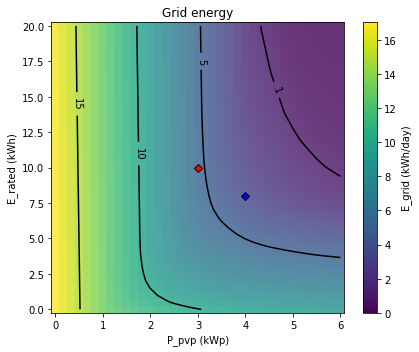

In [372]:
fig, ax = plt.subplots(figsize=(6,5))

imparams = dict(origin='lower',
                extent=[-dP/2, P_pv_max+dP/2, -dE/2, E_rated_max+dE/2],
                aspect='auto')
im = ax.imshow(E_grid_rs, **imparams, alpha=0.8)
ax.plot(3, 10, 'rD', mec='k')
ax.plot(4, 8, 'bD', mec='k')
CS = ax.contour(XP, YE, E_grid_rs, [1, 5, 10, 15], colors='k')
ax.clabel(CS, fmt='%.0f')
cbar = fig.colorbar(im)
cbar.set_label('E_grid (kWh/day)')
cbar.solids.set_edgecolor("face") # hack fix of overlap issue https://github.com/matplotlib/matplotlib/issues/1188
ax.set(title='Grid energy', xlabel='P_pvp (kWp)', ylabel='E_rated (kWh)')
fig.tight_layout();

fig.savefig('Sizing_E_grid_heatmap.png', dpi=150)

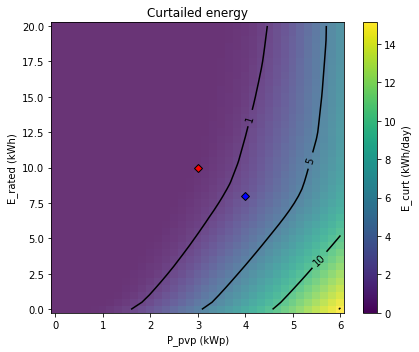

In [371]:
fig, ax = plt.subplots(figsize=(6,5))

im = ax.imshow(E_curt_rs, **imparams, alpha=0.8)
ax.plot(3, 10, 'rD', mec='k')
ax.plot(4, 8, 'bD', mec='k')
#ax.plot(3.5, 7, 'bD', mec='k')
CS = ax.contour(XP, YE, E_curt_rs, [1, 5, 10, 15], colors='k')
ax.clabel(CS, fmt='%.0f')
cbar = fig.colorbar(im)
cbar.set_label('E_curt (kWh/day)')
cbar.solids.set_edgecolor("face") # hack fix of overlap issue https://github.com/matplotlib/matplotlib/issues/1188

ax.set(title='Curtailed energy', xlabel='P_pvp (kWp)', ylabel='E_rated (kWh)')
fig.tight_layout()

fig.savefig('Sizing_E_curt_heatmap.png', dpi=150)

### Cost analysis

* 2 €/Wc (HT, pour 9 à 36 kWc, ISB http://www.photovoltaique.info/Couts-d-investissement.html)
* 0.5 €/kWh ([Tesla Powerwall](https://www.tesla.com/fr_FR/powerwall) 7 k€/13.5 kWh)

In [101]:
cP = 2 # k€/kWp
cE = 0.5 # k€/kWh
cost = XP*cP + YE*cE

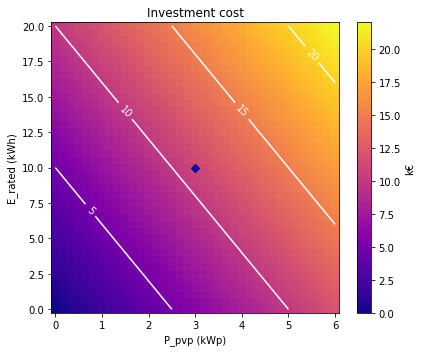

In [263]:
fig, ax = plt.subplots(figsize=(6,5))

im = ax.imshow(cost, **imparams, cmap='plasma', alpha=1)
ax.plot(3, 10, 'bD', mec='k')
CS = ax.contour(XP, YE, cost, [5, 10, 15, 20], colors='w')
ax.clabel(CS, fmt='%.0f')
cbar = fig.colorbar(im)
cbar.set_label('k€')

ax.set(title='Investment cost', xlabel='P_pvp (kWp)', ylabel='E_rated (kWh)')
fig.tight_layout();

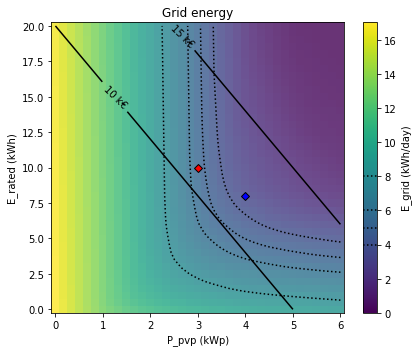

In [373]:
fig, ax = plt.subplots(figsize=(6,5))

im = ax.imshow(E_grid_rs, **imparams, alpha=0.8)
ax.plot(3, 10, 'rD', mec='k')
ax.plot(4, 8, 'bD', mec='k')
#ax.plot(3.5, 7, 'bD', mec='k')
CSE = ax.contour(XP, YE, E_grid_rs, [4, 5, 6, 8], colors='k', linestyles=':')


CSc = ax.contour(XP, YE, cost, [10, 15], colors='k')
ax.clabel(CSc, fmt='%.0f k€')
cbar = fig.colorbar(im)
cbar.add_lines(CSE)
cbar.lines[0].set_linestyles(':')
cbar.set_label('E_grid (kWh/day)')
cbar.solids.set_edgecolor("face") # hack fix of overlap issue https://github.com/matplotlib/matplotlib/issues/1188

ax.set(title='Grid energy', xlabel='P_pvp (kWp)', ylabel='E_rated (kWh)')
fig.tight_layout();

#### Total cost

hyp: E_grid priced at 0.2 €/kWh on 20 years

In [302]:
c_grid = 0.24 # €/kWh on 20 years
cost_tot = cost+E_grid_rs*20*365.25*c_grid/1000

In [351]:
def total_cost_map(c_grid, save=False):
    fig, ax = plt.subplots(figsize=(6,5))
    
    cost_tot = cost+E_grid_rs*20*365.25*c_grid/1000
    im = ax.imshow(cost_tot, **imparams, cmap='plasma', vmin=15, vmax=40)
    #ax.plot(3, 10, 'D', mec='k', color=(0,1,0), label='bench sizing')
    CS = ax.contour(XP, YE, cost_tot, [16, 18, 20], colors='w')
    ax.clabel(CS, fmt='%.0f')
    cbar = fig.colorbar(im)
    cbar.add_lines(CS)
    cbar.set_label('k€')

    ax.set(
        title='Total cost\n on 20 yr, grid at {:.2f} €/kWh'.format(c_grid),
        xlabel='P_pvp (kWp)',
        ylabel='E_rated (kWh)'
    )
    fig.tight_layout();
    if save:
        fig.savefig('Total_cost_map_grid{:.2f}.png'.format(c_grid), dpi=150)

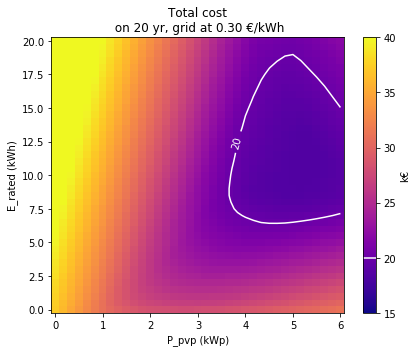

In [352]:
total_cost_map(0.30)

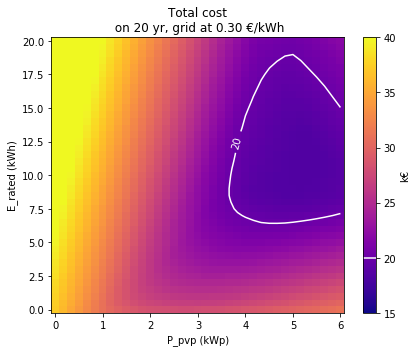

In [353]:
for cgrid in np.arange(15, 31)/100:
    plt.close()
    total_cost_map(cgrid, save=True)

#### 3D plot

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
a= 1

In [250]:
%matplotlib inline

[Text(0.5,0,'E_rated (kWh)'),
 Text(0.5,0,'P_pvp (kWp)'),
 Text(0.5,0.92,'E grid')]

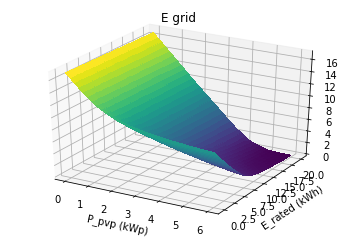

In [354]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(XP, YE, E_grid_rs, cmap='viridis', antialiased=False)
ax.set(title='E grid', xlabel='P_pvp (kWp)', ylabel='E_rated (kWh)')

[Text(0.5,0,'E_rated (kWh)'),
 Text(0.5,0,'P_pvp (kWp)'),
 Text(0.5,0.92,'Total cost')]

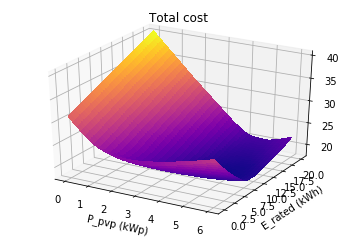

In [277]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(XP, YE, cost_tot, cmap='plasma', antialiased=False)
ax.set(title='Total cost', xlabel='P_pvp (kWp)', ylabel='E_rated (kWh)')

## Uncertainty of the energy statistics

### Load input data bootstrap (P_sun, P_load)

load bootstrap data generated in [data_variability_bootstrap.ipynb](../data/data_variability_bootstrap.ipynb)

TODO cut last 3 days

In [145]:
df_bs = pd.read_csv('../data/test-data_2011-11-29_33-days_bl-3_bs-400.csv', index_col=0, parse_dates=True)
df_bs.head(3)

,GC0,GG0,GC1,GG1,GC2,GG2,GC3,GG3,GC4,GG4,...,GC395,GG395,GC396,GG396,GC397,GG397,GC398,GG398,GC399,GG399
2011-11-29 00:00:00,0.468,0.0,0.456,0.0,0.338,0.0,0.538,0.0,0.510,0.0,...,0.494,0.0,0.482,0.0,0.510,0.0,0.358,0.0,0.586,0.0
2011-11-29 00:30:00,0.504,0.0,0.502,0.0,0.366,0.0,0.620,0.0,0.538,0.0,...,0.318,0.0,0.344,0.0,0.538,0.0,0.352,0.0,0.404,0.0
2011-11-29 01:00:00,0.394,0.0,0.500,0.0,0.568,0.0,0.510,0.0,0.448,0.0,...,0.326,0.0,0.376,0.0,0.448,0.0,0.268,0.0,0.574,0.0


In [149]:
nsamp = len(df_bs.columns)//2
nsamp

400

*to be continued* : e.g. scale solar power to 3 kW

In [152]:
P_load_bs = df_bs.iloc[:,range(0,nsamp*2, 2)]
P_load_bs.columns = range(nsamp)
P_load_bs.head(3)

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
2011-11-29 00:00:00,0.468,0.456,0.338,0.538,0.510,0.520,0.366,0.934,0.482,0.468,...,0.432,0.386,0.428,0.520,0.494,0.494,0.482,0.510,0.358,0.586
2011-11-29 00:30:00,0.504,0.502,0.366,0.620,0.538,0.528,0.414,0.820,0.344,0.504,...,0.316,0.266,0.710,0.526,0.482,0.318,0.344,0.538,0.352,0.404
2011-11-29 01:00:00,0.394,0.500,0.568,0.510,0.448,0.496,0.496,0.506,0.376,0.394,...,0.360,0.284,0.402,0.586,0.398,0.326,0.376,0.448,0.268,0.574


In [159]:
P_sun_1k_bs = df_bs.iloc[:,range(1,nsamp*2, 2)]/1.04
P_sun_1k_bs.columns = range(nsamp)
P_sun_1k_bs.head(3)

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
2011-11-29 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.011538,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-29 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-29 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


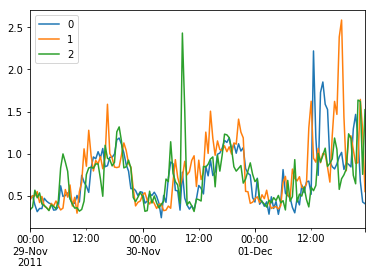

In [160]:
P_load_bs.iloc[:48*3,:3].plot()

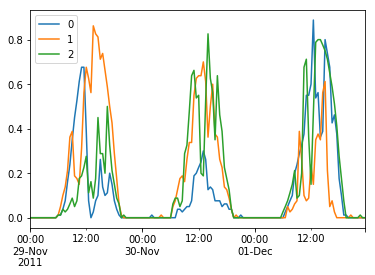

In [161]:
P_sun_bs.iloc[:48*3,:3].plot()

Batch sim ~ 16 s

In [166]:
40e-3 * 400

16.0

In [165]:
E_rated = 10 # kWh
P_pvp = 3 # kWp
bs_stats = []
for i in range(nsamp):
    stats = home_sim(E_rated, P_pvp, P_load_bs[i], P_sun_1k_bs[i])
    bs_stats.append(stats)

In [167]:
bs_stats = pd.DataFrame(bs_stats)
bs_stats.head()

,E_curt,E_grid,E_load,E_pv,E_sun
0,2.334802e-01,5.660129,16.820909,11.009265,11.242745
1,5.639044e-02,5.681879,17.249818,11.416424,11.472815
2,-1.690567e-16,5.576674,17.364727,11.636538,11.636538
3,1.266037e-01,4.197807,17.061879,12.712557,12.839161
4,1.196224e-01,4.954316,17.233848,12.128017,12.247640


In [194]:
bs_stats.describe(percentiles=[0.025, 0.975])

,E_curt,E_grid,E_load,E_pv,E_sun
count,4.000000e+02,400.000000,400.000000,400.000000,400.000000
mean,1.936261e-01,4.857416,16.738370,11.783853,11.977479
std,1.367145e-01,0.801623,0.406624,0.683772,0.747162
min,-3.254972e-16,2.025336,15.447758,9.988627,10.034965
2.5%,-1.524454e-16,3.119332,15.991741,10.455425,10.554650
50%,1.789499e-01,4.926861,16.728576,11.770777,11.970848
97.5%,5.423876e-01,6.228127,17.581536,13.232820,13.513105
max,6.778007e-01,6.917001,18.006970,13.950861,14.369056


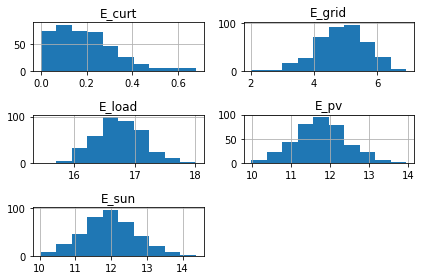

In [170]:
bs_stats.hist();
plt.tight_layout()

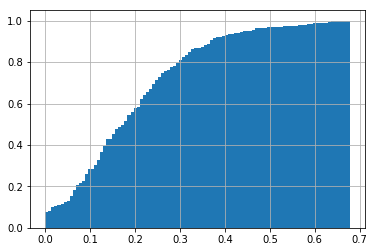

In [364]:
bs_stats.E_curt.hist(cumulative=True, bins=100, density=True);

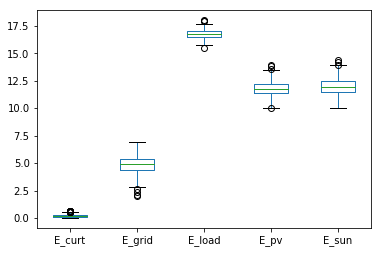

In [175]:
bs_stats.plot.box()

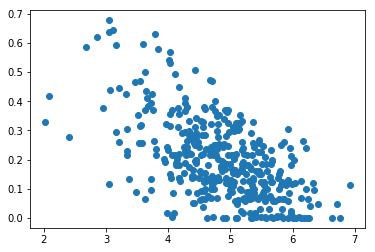

In [171]:
plt.plot(bs_stats.E_grid, bs_stats.E_curt, 'o')

In [176]:
from pandas.plotting import scatter_matrix

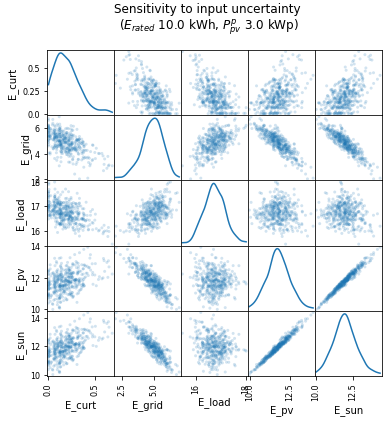

In [365]:
scatter_matrix(bs_stats, alpha=0.2, figsize=(6, 6), diagonal='kde')
title = 'Sensitivity to input uncertainty \n' +\
        '($E_{{rated}}$ {:.1f} kWh, $P_{{pv}}^p$ {:.1f} kWp)'.format(E_rated, P_pvp)
plt.suptitle(title);
plt.savefig('Input_uncertain_scat.pdf')

---

Plot trajectories. NOT YET DONE

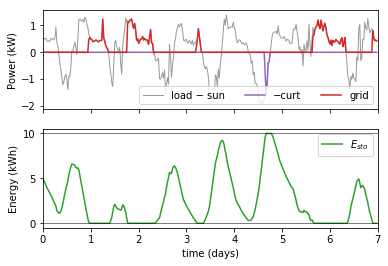

In [150]:
fig, ax = plt.subplots(2,1, sharex=True)

ax[0].plot(td, P_nl, label='load − sun',
           color=(0.6,)*3, lw=1)

ax[0].plot(td, -P_curt, label='−curt',
           color='tab:purple')

ax[0].plot(td, P_grid, label='grid',
           color='tab:red')

ax[0].legend(ncol=4)
ax[0].set(
    ylabel='Power (kW)'
)

ax[1].plot(td, E_sto, label='$E_{sto}$',
           color='tab:green');
ax[1].axhline(0, color='k', lw=0.5)
ax[1].axhline(E_rated, color='k', lw=0.5)

ax[1].legend()
ax[1].set(
    xlabel='time (days)',
    ylabel='Energy (kWh)',
    ylim=(-.05*E_rated, 1.05*E_rated),
    xlim=(0, n//48)
);